## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)

### Среда выполнения

Определим среду выполнения, Google Colab или локальный компьютер.

In [1]:
Colab = True

### Импорт библиотек

In [2]:
!pip install py_essentials
!pip install efficientnet_pytorch

  Created wheel for py-essentials: filename=py_essentials-1.4.12-py3-none-any.whl size=6938 sha256=e143b90fe4af964f59fa0ea9a00415dadad465ca3c0812e2fd9d59a62b6e80d9
  Stored in directory: /root/.cache/pip/wheels/c3/9b/0a/0168a3bae2fc798c0209266f77b6dc3aae04d0bb9ea28b0dab
Successfully built py-essentials
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=0005ea07898a8988d642fc4f7953b3b934a1750b3dfe11a0742d0db4b609b3f6
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [3]:
import os
import cv2
import torch
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from sklearn.metrics import f1_score
from tqdm import tqdm, tqdm_notebook
from py_essentials import hashing as hs
from torchvision import transforms, models
from efficientnet_pytorch import EfficientNet
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

plt.rcParams['font.size'] = '12'

### Девайс 

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')  
device

device(type='cuda', index=0)

In [5]:
if device.type == 'cuda':
    !nvidia-smi

Thu Nov 18 10:58:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    34W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Загрузка данных

In [6]:
if Colab:
    from google.colab import drive
    drive.mount('/content/gdrive/')    
    !unzip -q /content/gdrive/MyDrive/simpsons/journey-springfield.zip -d /content
else:
    !unzip -q ./journey-springfield.zip

Mounted at /content/gdrive/


In [7]:
BASE_DIR = Path('./')
TRAIN_DIR = Path('./train/simpsons_dataset')
TEST_DIR = Path('./testset/testset')

### Exploration data analysis

In [8]:
persons = []
files = []

for folder in os.listdir(TRAIN_DIR):
    for file in os.listdir(os.path.join(TRAIN_DIR, folder)):
        persons.append(folder)
        files.append(os.path.join(folder, file))  

In [9]:
train_df = pd.DataFrame(data={'persona':persons, 'image_path':files})
train_df.head()

,persona,image_path
0,groundskeeper_willie,groundskeeper_willie/pic_0116.jpg
1,groundskeeper_willie,groundskeeper_willie/pic_0099.jpg
2,groundskeeper_willie,groundskeeper_willie/pic_0087.jpg
3,groundskeeper_willie,groundskeeper_willie/pic_0082.jpg
4,groundskeeper_willie,groundskeeper_willie/pic_0026.jpg


In [10]:
train_df.describe()

,persona,image_path
count,20933,20933
unique,42,20933
top,homer_simpson,edna_krabappel/pic_0448.jpg
freq,2246,1


Датасет содержит 20933 изображения в 42 классах. Наиболее часто встречающийся класс - "homer_simpson" с 2246 изображениями.

#### Пропорции классов

In [11]:
classcount = train_df.groupby('persona').count().reset_index()
classcount = classcount.rename(columns={"persona": "class", "image_path": "count"})
classcount

,class,count
0,abraham_grampa_simpson,913
1,agnes_skinner,42
2,apu_nahasapeemapetilon,623
3,barney_gumble,106
4,bart_simpson,1342
5,carl_carlson,98
6,charles_montgomery_burns,1193
7,chief_wiggum,986
8,cletus_spuckler,47
9,comic_book_guy,469


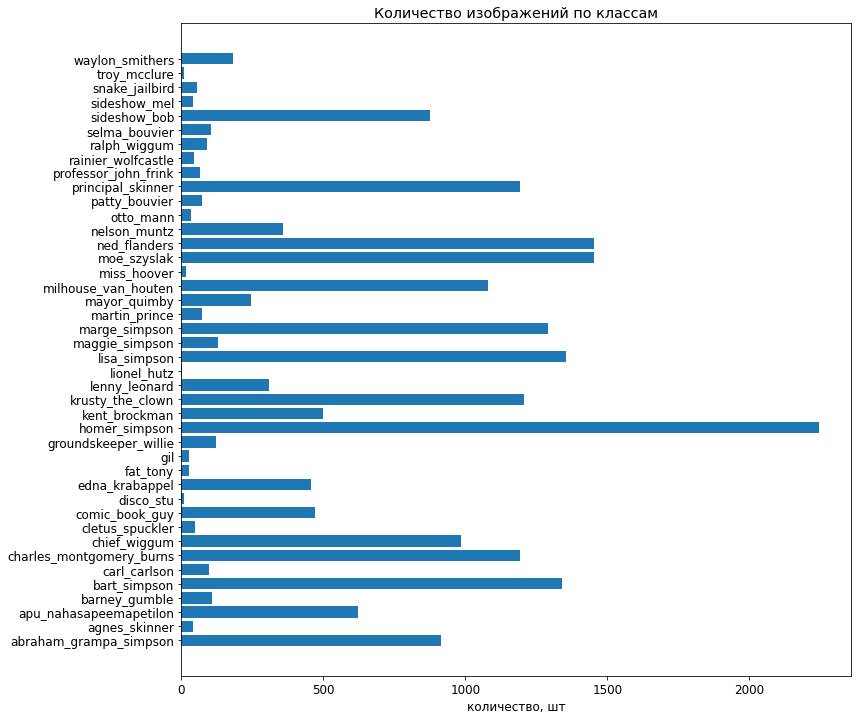

In [12]:
plt.figure(figsize=(12, 12))
plt.barh(classcount['class'], classcount['count'])
plt.title("Количество изображений по классам")
plt.xlabel("количество, шт")
plt.show()

Наблюдается сильный дисбаланс количества изображений по классам. Вероятно потребуется дополнительная балансировка.

#### Статистики изображений

In [13]:
image_info = []

for file in train_df.image_path:
    with Image.open(TRAIN_DIR / file) as img:
        width, height = img.size
        mode = img.mode
        file_hash = hs.fileChecksum(TRAIN_DIR / file, "sha256")    
        image_info.append((width, height, mode, file_hash))
        
print(f'Обработано {len(image_info)} файлов')

train_df['width'], train_df['height'], train_df['mode'], train_df['hash'] = zip(*image_info)
train_df['aspect_ratio'] = train_df['width'] / train_df['height']
train_df.head()

Обработано 20933 файлов


,persona,image_path,width,height,mode,hash,aspect_ratio
0,groundskeeper_willie,groundskeeper_willie/pic_0116.jpg,640,480,RGB,538b31b45051ad0d2e610de24693f217995b505b30964f...,1.333333
1,groundskeeper_willie,groundskeeper_willie/pic_0099.jpg,288,416,RGB,bef93e8ab32b9e3b3c57dd0c405f647683c65ff32036cc...,0.692308
2,groundskeeper_willie,groundskeeper_willie/pic_0087.jpg,288,416,RGB,7e5ed793d73b1f0b06a642c10d45f105273b6ac5e5069e...,0.692308
3,groundskeeper_willie,groundskeeper_willie/pic_0082.jpg,576,416,RGB,5e298e96eb070b3a78559d2f13ab94f565b97e0de5ae90...,1.384615
4,groundskeeper_willie,groundskeeper_willie/pic_0026.jpg,312,352,RGB,6a133a666580b19ea7d8b2644379284ee0c62bf24324e8...,0.886364


In [14]:
train_df.describe(include='all')

,persona,image_path,width,height,mode,hash,aspect_ratio
count,20933,20933,20933.000000,20933.000000,20933,20933,20933.000000
unique,42,20933,NaN,NaN,1,20927,NaN
top,homer_simpson,edna_krabappel/pic_0448.jpg,NaN,NaN,RGB,73be3b84ff46300dfdf7595d9c22d65e4ae08625a0369b...,NaN
freq,2246,1,NaN,NaN,20933,2,NaN
mean,NaN,NaN,409.300865,416.877562,NaN,NaN,0.994675
std,NaN,NaN,149.804210,62.214658,NaN,NaN,0.360452
min,NaN,NaN,256.000000,256.000000,NaN,NaN,0.288288
25%,NaN,NaN,288.000000,379.000000,NaN,NaN,0.666667
50%,NaN,NaN,320.000000,432.000000,NaN,NaN,0.886364
75%,NaN,NaN,576.000000,480.000000,NaN,NaN,1.333333


Все изображения имеют RGB формат

#### Дубликаты изображений

In [15]:
train_df_duplicates = train_df[train_df.duplicated(subset='hash', keep=False)]
train_df_duplicates

,persona,image_path,width,height,mode,hash,aspect_ratio
3512,mayor_quimby,mayor_quimby/pic_0054.jpg,576,416,RGB,ba92498a81aba03e7c8bb70b1ab52c06f270b6cb80609e...,1.384615
3549,mayor_quimby,mayor_quimby/pic_0176.jpg,576,416,RGB,ba92498a81aba03e7c8bb70b1ab52c06f270b6cb80609e...,1.384615
11932,cletus_spuckler,cletus_spuckler/pic_0010.jpg,320,480,RGB,ba88466d90877dd72a49c363de906f529ae62afe6a1af1...,0.666667
11941,cletus_spuckler,cletus_spuckler/pic_0012.jpg,320,480,RGB,ba88466d90877dd72a49c363de906f529ae62afe6a1af1...,0.666667
12087,waylon_smithers,waylon_smithers/pic_0038.jpg,312,352,RGB,353d281d56629989917a992c1e274a109552f609b46535...,0.886364
12142,waylon_smithers,waylon_smithers/pic_0051.jpg,312,352,RGB,353d281d56629989917a992c1e274a109552f609b46535...,0.886364
15921,rainier_wolfcastle,rainier_wolfcastle/pic_0016.jpg,288,432,RGB,57196ef6be5da07e43d1893a2f57248f7b2c4987f1d703...,0.666667
15924,rainier_wolfcastle,rainier_wolfcastle/pic_0011.jpg,288,432,RGB,57196ef6be5da07e43d1893a2f57248f7b2c4987f1d703...,0.666667
17370,lenny_leonard,lenny_leonard/pic_0257.jpg,312,352,RGB,93ecb58afbdbe246e461221de93a25ad24b2bc881c1bcf...,0.886364
17475,lenny_leonard,lenny_leonard/pic_0262.jpg,312,352,RGB,93ecb58afbdbe246e461221de93a25ad24b2bc881c1bcf...,0.886364


Все дублированные изображения находятся в пределах одного класса, по этому их можно не удалять

#### Размеры и пропорции изображений

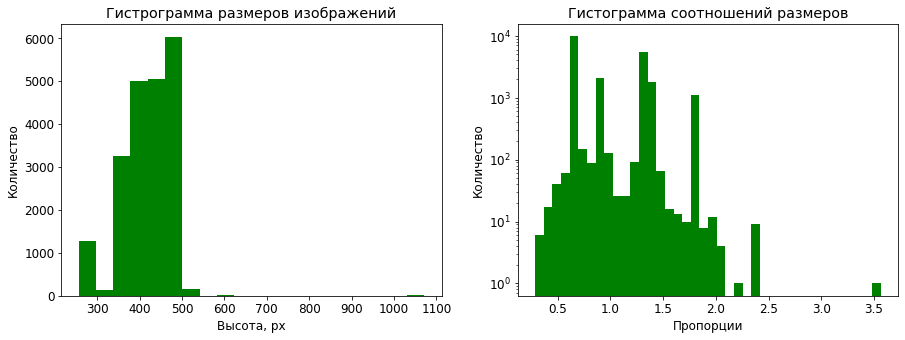

In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(train_df.height, bins=20, color='green')
plt.title('Гистрограмма размеров изображений')
plt.xlabel('Высота, px')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
plt.hist(train_df.aspect_ratio, bins=40, log=True, color='green')
plt.title('Гистограмма соотношений размеров')
plt.xlabel('Пропорции')
plt.ylabel('Количество')

plt.show()

Большинство изображение имеют размеры от 300px до 500px. Пропорции совершенно различные, как альбомные, так и портретные.

Отобразим две самые крупные картинки

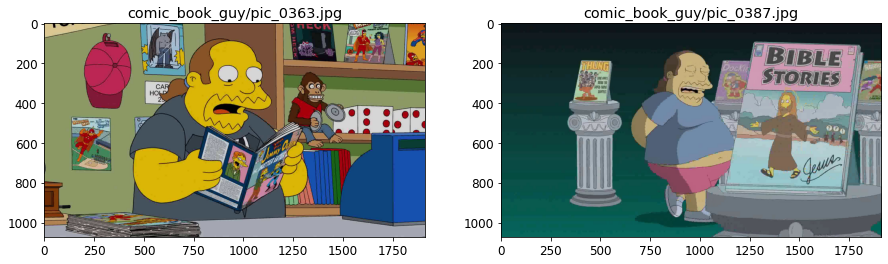

In [17]:
plt.figure(figsize=(15, 5))
large = train_df.sort_values(['width'], ascending=False).head(2)
i = 0

for file in large.image_path:
    i += 1
    plt.subplot(1, 2, i)
    image = Image.open(TRAIN_DIR / file)
    plt.imshow(image)
    plt.title(file)
plt.show()

#### Уровень яркости изображений

In [18]:
brightness = []

for file in train_df.image_path:
    image = cv2.imread(str(TRAIN_DIR / file))
    hsld  = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    Bchannels = hsld[:,:,1]
    Blevel = cv2.mean(Bchannels)[0]
    brightness.append(Blevel)
    
train_df['brightness'] = brightness
train_df.head()

,persona,image_path,width,height,mode,hash,aspect_ratio,brightness
0,groundskeeper_willie,groundskeeper_willie/pic_0116.jpg,640,480,RGB,538b31b45051ad0d2e610de24693f217995b505b30964f...,1.333333,93.853268
1,groundskeeper_willie,groundskeeper_willie/pic_0099.jpg,288,416,RGB,bef93e8ab32b9e3b3c57dd0c405f647683c65ff32036cc...,0.692308,99.074644
2,groundskeeper_willie,groundskeeper_willie/pic_0087.jpg,288,416,RGB,7e5ed793d73b1f0b06a642c10d45f105273b6ac5e5069e...,0.692308,118.113048
3,groundskeeper_willie,groundskeeper_willie/pic_0082.jpg,576,416,RGB,5e298e96eb070b3a78559d2f13ab94f565b97e0de5ae90...,1.384615,91.084498
4,groundskeeper_willie,groundskeeper_willie/pic_0026.jpg,312,352,RGB,6a133a666580b19ea7d8b2644379284ee0c62bf24324e8...,0.886364,125.395888


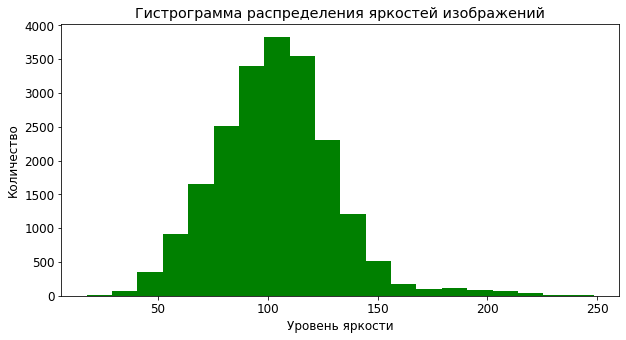

In [19]:
plt.figure(figsize=(10, 5))

plt.hist(train_df.brightness, bins=20, color='green')
plt.title('Гистрограмма распределения яркостей изображений')
plt.xlabel('Уровень яркости')
plt.ylabel('Количество')
plt.show()

Отобразим самое яркое и самое затемнённое изображения

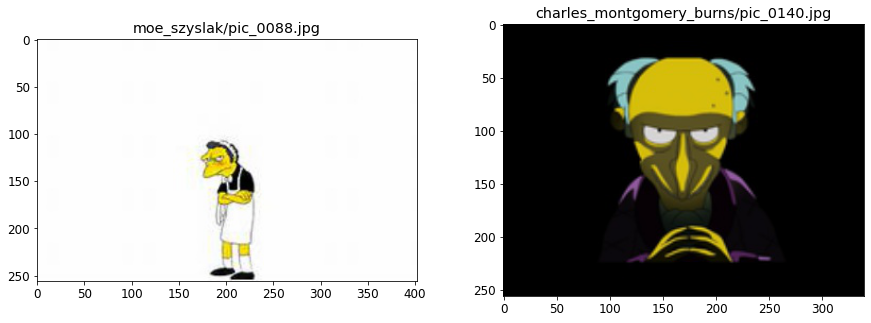

In [20]:
plt.figure(figsize=(15, 5))
bright_df = train_df.sort_values(['brightness'], ascending=False).iloc[[0, -1]]
i = 0

for file in bright_df.image_path:
    i += 1
    plt.subplot(1, 2, i)
    image = Image.open(TRAIN_DIR / file)
    plt.imshow(image)
    plt.title(file)
plt.show()

Уровень яркости пограничных изображений вполне допустим. Визуально персонаж на картинке определяется без затруднений

#### Сохранение датафрейма

In [21]:
train_df.to_csv(BASE_DIR/'df_train.csv', sep=',', index_label='index')

### Подготовка данных для обучения моделей

In [22]:
df_train = pd.read_csv(BASE_DIR/'df_train.csv', sep=',', index_col='index')
df_train.drop(['mode', 'hash'], inplace=True, axis=1)  # удалим не нужные более столбцы
df_train.head()

,persona,image_path,width,height,aspect_ratio,brightness
index,,,,,,
0,groundskeeper_willie,groundskeeper_willie/pic_0116.jpg,640,480,1.333333,93.853268
1,groundskeeper_willie,groundskeeper_willie/pic_0099.jpg,288,416,0.692308,99.074644
2,groundskeeper_willie,groundskeeper_willie/pic_0087.jpg,288,416,0.692308,118.113048
3,groundskeeper_willie,groundskeeper_willie/pic_0082.jpg,576,416,1.384615,91.084498
4,groundskeeper_willie,groundskeeper_willie/pic_0026.jpg,312,352,0.886364,125.395888


In [23]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# количество классов:
n_classes = len(np.unique(df_train.persona))

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже используем враппер над датасетом для удобной работы. Cтоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что переопределяеncz метод __getitem__ для удобства работы с этой структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следует привести их к одному размер (это делает метод  _prepare_sample) 

Обучим LabelEncoder на всём датасете

In [70]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [71]:
label_encoder = LabelEncoder()
train_val_labels = [path.parent.name for path in train_val_files]
label_encoder.fit(train_val_labels)

with open('label_encoder.pkl', 'wb') as le_dump_file:
    pickle.dump(label_encoder, le_dump_file)

In [72]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который параллельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, rescale_size):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        # размер, в который нужно преобразовать изображение
        self.rescale_size = rescale_size

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        
        self.label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize(size=(self.rescale_size, self.rescale_size)),
                transforms.CenterCrop(self.rescale_size),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=(0, 15)),
                transforms.RandAugment(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])      
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(self.rescale_size, self.rescale_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [73]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Разобъём данные на тренировочную и валидационную части

In [74]:
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

Создадим тренировочный и валидационный датасеты

In [75]:
train_dataset = SimpsonsDataset(train_files, mode='train', rescale_size=RESCALE_SIZE)
val_dataset = SimpsonsDataset(val_files, mode='val', rescale_size=RESCALE_SIZE)

Посмотрим на героев внутри тренировочного датасета

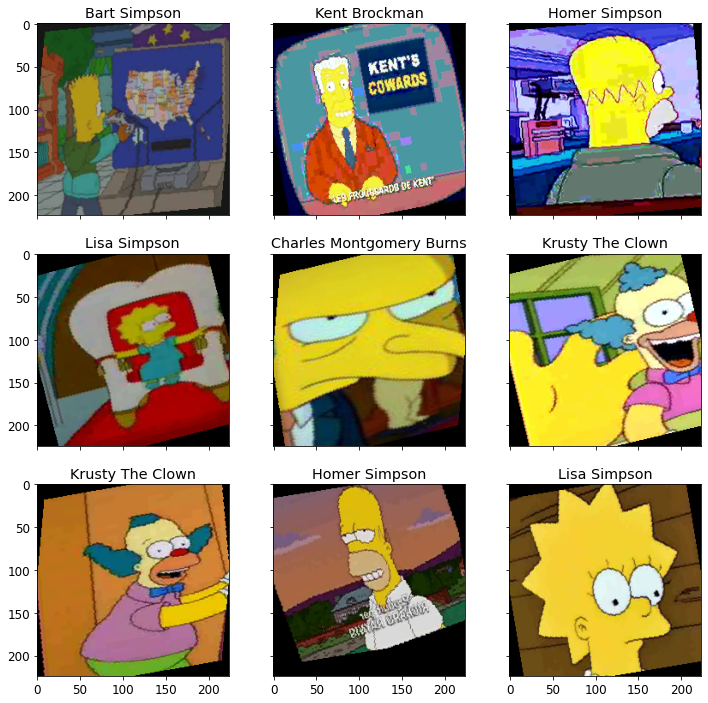

In [76]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 10000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

И внутри валидационного датасета

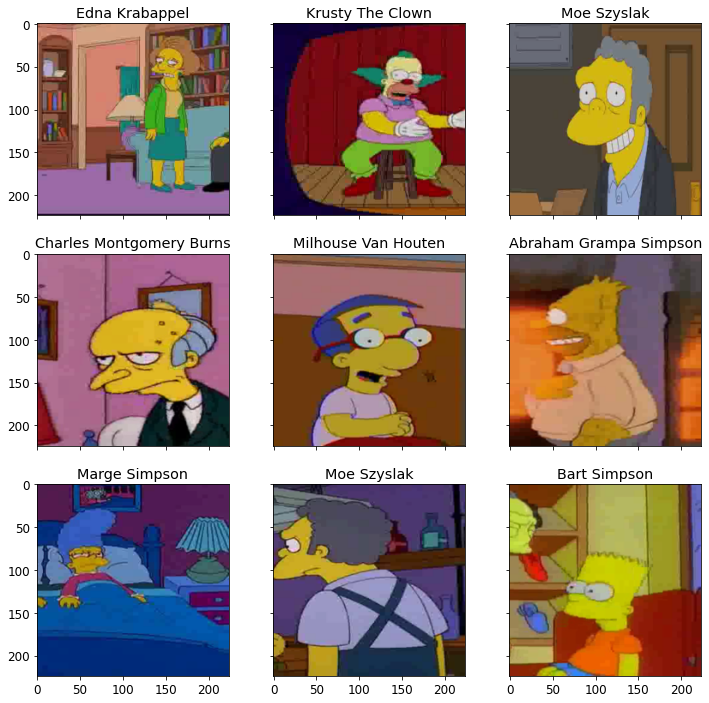

In [77]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 5000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

Кроме того, взглянем как изменятся один персонаж под действием аугментаций

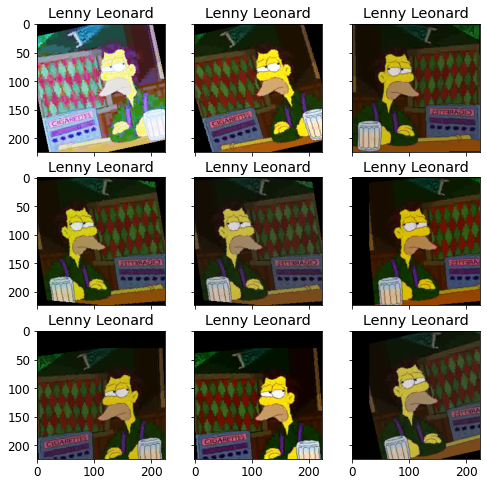

In [78]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(8000, 8001))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), title=img_label,plt_ax=fig_x)

### OverSampling

Т.к. классы сильно не сбалансированны, проведём семпилирование недостающих классов

Список классов для train и val

In [79]:
train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]     

In [80]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

Cловарь в котором ключи - персонажи, а значения - списки с путями к картинкам

In [81]:
dct_path_train = create_dct_path_labels(train_files, train_labels)

Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе

In [82]:
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [83]:
def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

In [84]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

In [85]:
# класс:количество картинок для train
sampling_df = pd.DataFrame.from_records([create_dct_from_labels(new_train_label)]).T.reset_index()
sampling_df.rename(columns={"index": "class", 0: "count"}, inplace=True)
sampling_df

,class,count
0,abraham_grampa_simpson,685
1,agnes_skinner,100
2,apu_nahasapeemapetilon,467
3,barney_gumble,100
4,bart_simpson,1006
5,carl_carlson,100
6,charles_montgomery_burns,895
7,chief_wiggum,739
8,cletus_spuckler,100
9,comic_book_guy,352


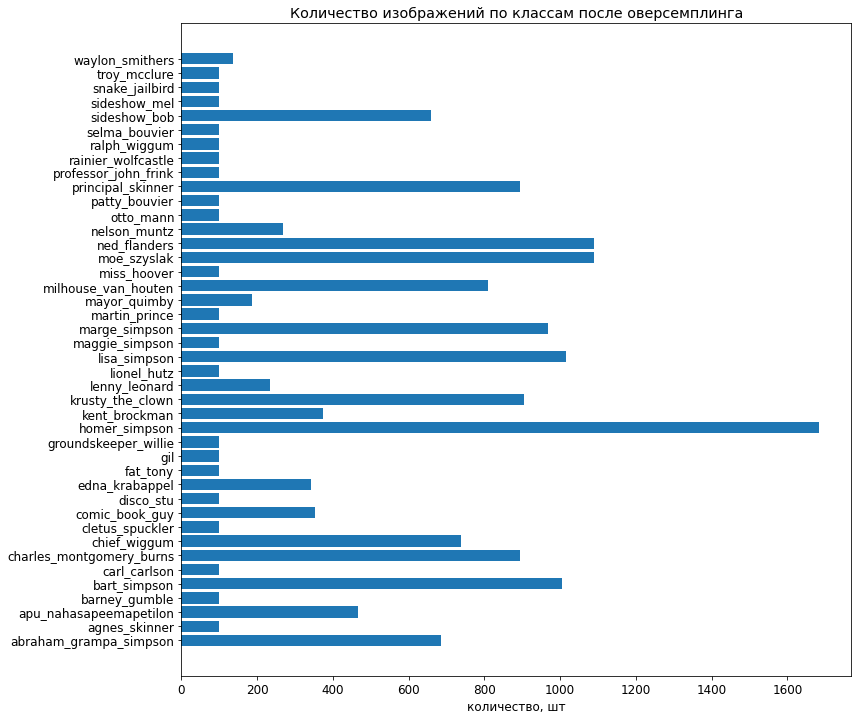

In [86]:
plt.figure(figsize=(12, 12))
plt.barh(sampling_df['class'], sampling_df['count'])
plt.title("Количество изображений по классам после оверсемплинга")
plt.xlabel("количество, шт")
plt.show()

### Построение нейросети

В качестве основной модели используем Efficientnet B1 с полностью размороженными слоями

In [89]:
model = models.efficientnet_b1(pretrained=True)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=n_classes, bias=True))

Снова создадим датасеты, но уже после оверсемплинга

In [90]:
train_dataset = SimpsonsDataset(new_train_files, mode='train', rescale_size=RESCALE_SIZE)
val_dataset = SimpsonsDataset(val_files, mode='val', rescale_size=RESCALE_SIZE)

In [91]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

Функции необходимые для обучения модели

In [92]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    lb = torch.tensor([])
    pr = torch.tensor([])
  
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        lb = torch.cat((lb, labels.data.cpu()))
        pr = torch.cat((pr, preds.cpu()))
        
        # очистка кеша
        inputs.cpu()
        labels.cpu()
        loss.cpu()
        preds.cpu()
        del inputs
        del labels
        del loss
        del preds
        torch.cuda.empty_cache()
    
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    train_f1 = f1_score(lb.numpy(), pr.numpy(), average='weighted')
    
    return train_loss, train_acc, train_f1

In [93]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    lb = torch.tensor([])
    pr = torch.tensor([])

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        lb = torch.cat((lb, labels.data.cpu()))
        pr = torch.cat((pr, preds.cpu()))
        
        # очистка кеша
        inputs.cpu()
        labels.cpu()
        loss.cpu()
        preds.cpu()
        del inputs
        del labels
        del loss
        del preds
        torch.cuda.empty_cache()
    
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    val_f1 = f1_score(lb.numpy(), pr.numpy(), average='weighted')
    
    return val_loss, val_acc, val_f1

In [95]:
def train(train_files, val_files, model, epochs, batch_size):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    best_model_weights = model.state_dict()
    best_f1 = 0.0
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {v_loss:0.4f} \
    train_acc: {t_acc:0.4f} val_acc: {v_acc:0.4f} \
    train_f1: {t_f1:0.4f} val_f1: {v_f1:0.4f}" 

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[2, 4, 6, 8], gamma=0.6)

        for epoch in range(epochs):
            train_loss, train_acc, train_f1 = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc, val_f1 = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, train_f1, val_loss, val_acc, val_f1))

            # сохранение лучших весов модели
            if val_f1 > best_f1:
                best_f1 = val_f1
                best_model_weights = model.state_dict()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc,\
                                           t_f1=train_f1, v_f1=val_f1))
            scheduler.step()
            torch.cuda.empty_cache()
    
    # загрузим лучшие веса
    model.load_state_dict(best_model_weights)
          
    return history

In [96]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
            # очистка кеша
            inputs.cpu()
            del inputs
            torch.cuda.empty_cache()
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

### Обучение модели

In [97]:
history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=32)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.6594777361709503


epoch:  10%|█         | 1/10 [11:34<1:44:08, 694.30s/it]


Epoch 001 train_loss: 1.6595 val_loss: 0.3478     train_acc: 0.6133 val_acc: 0.9280     train_f1: 0.5823 val_f1: 0.9181
loss 0.284165818983544


epoch:  20%|██        | 2/10 [23:04<1:32:14, 691.77s/it]


Epoch 002 train_loss: 0.2842 val_loss: 0.1670     train_acc: 0.9235 val_acc: 0.9572     train_f1: 0.9222 val_f1: 0.9566
loss 0.1248063386774303


epoch:  30%|███       | 3/10 [34:33<1:20:33, 690.50s/it]


Epoch 003 train_loss: 0.1248 val_loss: 0.1283     train_acc: 0.9674 val_acc: 0.9669     train_f1: 0.9673 val_f1: 0.9672
loss 0.09317587762266248


epoch:  40%|████      | 4/10 [46:01<1:08:56, 689.42s/it]


Epoch 004 train_loss: 0.0932 val_loss: 0.1188     train_acc: 0.9749 val_acc: 0.9694     train_f1: 0.9748 val_f1: 0.9693
loss 0.05811613038053819


epoch:  50%|█████     | 5/10 [57:24<57:15, 687.16s/it]


Epoch 005 train_loss: 0.0581 val_loss: 0.1106     train_acc: 0.9841 val_acc: 0.9717     train_f1: 0.9841 val_f1: 0.9714
loss 0.04806763302560245


epoch:  60%|██████    | 6/10 [1:08:44<45:39, 684.87s/it]


Epoch 006 train_loss: 0.0481 val_loss: 0.1080     train_acc: 0.9877 val_acc: 0.9719     train_f1: 0.9877 val_f1: 0.9717
loss 0.0348159260398202


epoch:  70%|███████   | 7/10 [1:20:07<34:12, 684.12s/it]


Epoch 007 train_loss: 0.0348 val_loss: 0.1054     train_acc: 0.9900 val_acc: 0.9740     train_f1: 0.9900 val_f1: 0.9739
loss 0.033964688810744506


epoch:  80%|████████  | 8/10 [1:31:28<22:46, 683.18s/it]


Epoch 008 train_loss: 0.0340 val_loss: 0.1051     train_acc: 0.9913 val_acc: 0.9755     train_f1: 0.9913 val_f1: 0.9755
loss 0.024448535017369877


epoch:  90%|█████████ | 9/10 [1:42:52<11:23, 683.49s/it]


Epoch 009 train_loss: 0.0244 val_loss: 0.1098     train_acc: 0.9933 val_acc: 0.9744     train_f1: 0.9933 val_f1: 0.9743
loss 0.028424890862971314


epoch: 100%|██████████| 10/10 [1:54:18<00:00, 685.85s/it]


Epoch 010 train_loss: 0.0284 val_loss: 0.1049     train_acc: 0.9922 val_acc: 0.9757     train_f1: 0.9922 val_f1: 0.9756


Сохраним веса модели

In [110]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/effnet_b1_v3.pth')

In [99]:
loss, acc, f1, val_loss, val_acc, val_f1 = zip(*history)

Явного переобучения модели не наблюдается

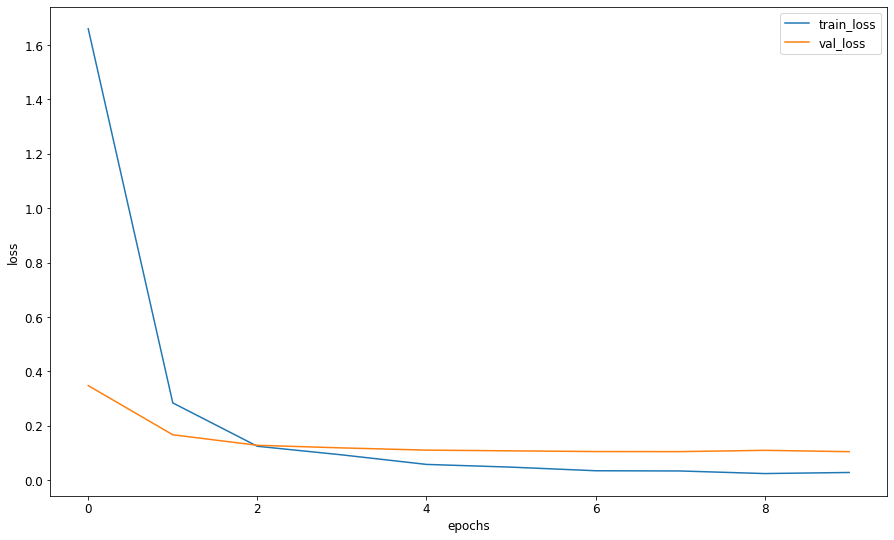

In [100]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [101]:
def predict_one_sample(model, inputs, device=device):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [102]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [103]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [104]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

Вычислим целевую метрику на валидационной выборке

In [105]:
f1_score(actual_labels, y_pred, average='weighted')

1.0

Сделаем визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах

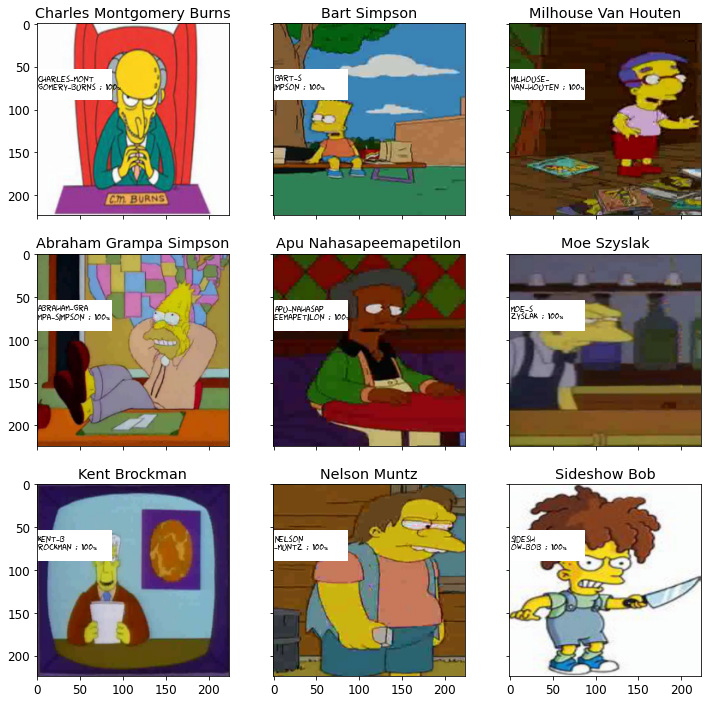

In [106]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,5000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [107]:
test_dataset = SimpsonsDataset(test_files, mode="test", rescale_size=224)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [108]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [109]:
my_submit.to_csv('/content/gdrive/MyDrive/cnn_v3.csv', index=False)

### Результат

**Score:** 0.99468